In [1]:
import pandas as pd

df= pd.read_csv('final/cleaned_AIS_data.csv')

C:\Users\joyji\AppData\Local\Temp\ipykernel_11412\2126499.py:3: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('final/cleaned_AIS_data.csv')


In [2]:
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,TransceiverClass,has_IMO,has_CallSign,VesselGroup,hour,day,month,day_of_week,week,transmission_interval
0,0,2023-04-02 19:08:58,49.29758,-123.03559,0.0,275.9,511.0,UNKNOWN,NaN,NaN,...,A,False,False,Not Available,19,2,4,6,13,NaN
1,9108431,2022-08-09 22:35:16,49.29482,-123.06083,6.9,81.4,81.0,UNKNOWN,NaN,NaN,...,B,False,False,Other,22,9,8,1,32,NaN
2,9108431,2022-08-09 22:37:57,49.29553,-123.05262,7.3,85.0,85.0,UNKNOWN,NaN,NaN,...,B,False,False,Other,22,9,8,1,32,161.0
3,9108431,2022-08-09 22:39:16,49.29597,-123.04853,7.6,92.5,92.0,UNKNOWN,NaN,NaN,...,B,False,False,Other,22,9,8,1,32,79.0
4,9108431,2022-08-09 22:41:35,49.29557,-123.04118,7.7,95.2,95.0,UNKNOWN,NaN,NaN,...,B,False,False,Other,22,9,8,1,32,139.0


In [3]:
# Group AIS data by each vessel (MMSI) and sort by time to create tracks
vessel_tracks = df.sort_values(by=['MMSI', 'BaseDateTime'])


vessel_tracks.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,TransceiverClass,has_IMO,has_CallSign,VesselGroup,hour,day,month,day_of_week,week,transmission_interval
0,0,2023-04-02 19:08:58,49.29758,-123.03559,0.0,275.9,511.0,UNKNOWN,NaN,NaN,...,A,False,False,Not Available,19,2,4,6,13,NaN
1,9108431,2022-08-09 22:35:16,49.29482,-123.06083,6.9,81.4,81.0,UNKNOWN,NaN,NaN,...,B,False,False,Other,22,9,8,1,32,NaN
2,9108431,2022-08-09 22:37:57,49.29553,-123.05262,7.3,85.0,85.0,UNKNOWN,NaN,NaN,...,B,False,False,Other,22,9,8,1,32,161.0
3,9108431,2022-08-09 22:39:16,49.29597,-123.04853,7.6,92.5,92.0,UNKNOWN,NaN,NaN,...,B,False,False,Other,22,9,8,1,32,79.0
4,9108431,2022-08-09 22:41:35,49.29557,-123.04118,7.7,95.2,95.0,UNKNOWN,NaN,NaN,...,B,False,False,Other,22,9,8,1,32,139.0


In [4]:
# Visual check of the first vessel's track

first_vessel_track = vessel_tracks[vessel_tracks['MMSI'] == vessel_tracks['MMSI'].iloc[0]]
print(first_vessel_track[['BaseDateTime', 'LAT', 'LON', 'SOG', 'COG']].head())

          BaseDateTime       LAT        LON  SOG    COG
0  2023-04-02 19:08:58  49.29758 -123.03559  0.0  275.9


In [5]:
!pip install folium

In [6]:
vessel_tracks['BaseDateTime'] = pd.to_datetime(vessel_tracks['BaseDateTime'])

# 1️⃣ Create a copy of the original dataset
vessel_tracks_downsampled = vessel_tracks.copy()

# 2️⃣ Downsample: Aggregate every 10 minutes to reduce data density
# This keeps the general movement patterns intact but reduces data redundancy.

vessel_tracks_downsampled = vessel_tracks_downsampled.groupby(
    ['MMSI', pd.Grouper(key='BaseDateTime', freq='10min')]
).agg({
    'LAT': 'mean',
    'LON': 'mean',
    'SOG': 'mean',
    'COG': 'mean',
    'Heading': 'mean'
}).reset_index()

print(f"📉 Downsampled dataset size: {len(vessel_tracks_downsampled)} entries")


📉 Downsampled dataset size: 559359 entries


🚢 Selected MMSI for comparison: 316026483


C:\Users\joyji\AppData\Local\Temp\ipykernel_11412\2960026546.py:33: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\joyji\.conda\envs\jupyter_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


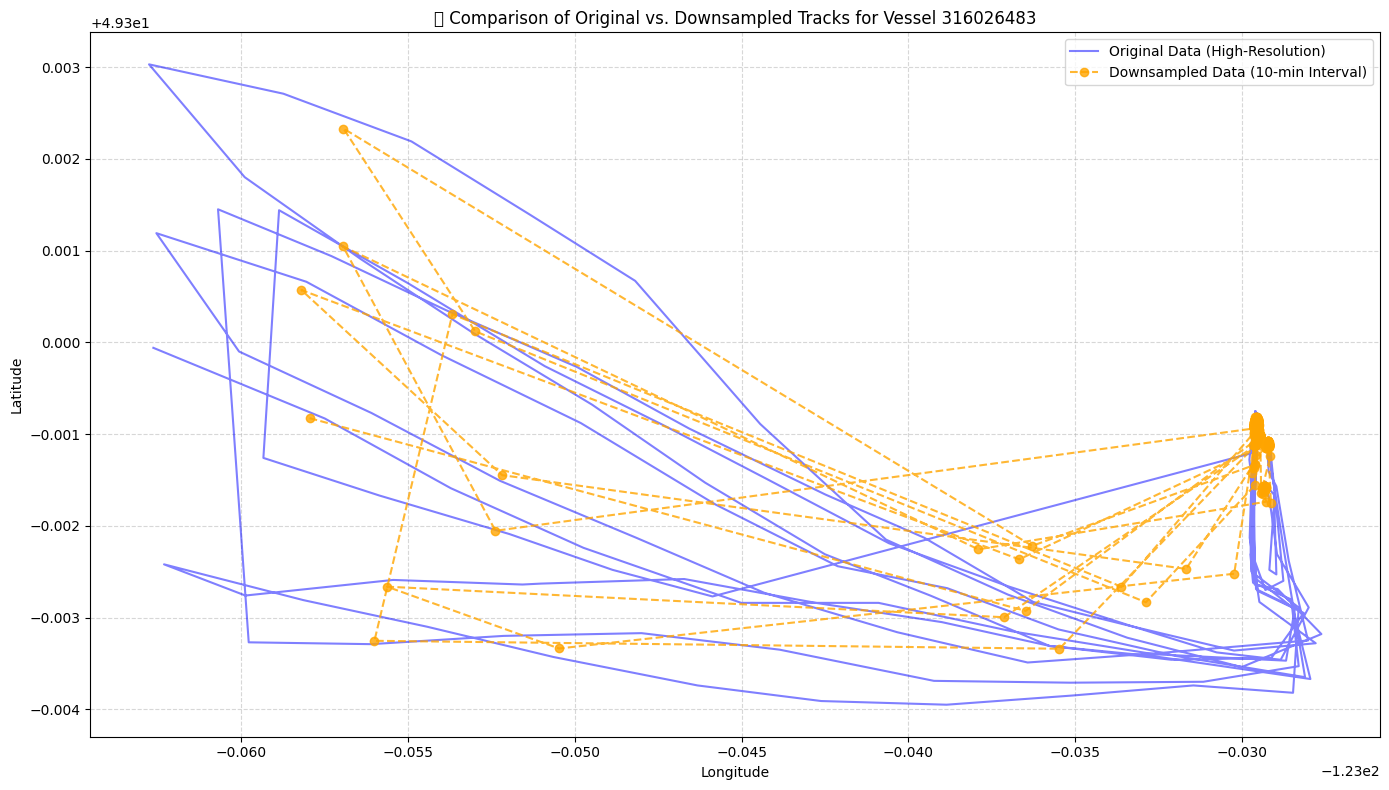

In [7]:
import matplotlib.pyplot as plt

# 1️⃣ Ensure 'BaseDateTime' is in datetime format
vessel_tracks['BaseDateTime'] = pd.to_datetime(vessel_tracks['BaseDateTime'])
vessel_tracks_downsampled['BaseDateTime'] = pd.to_datetime(vessel_tracks_downsampled['BaseDateTime'])

# 2️⃣ Select a specific vessel for clearer comparison (e.g., one with high activity)
selected_mmsi = vessel_tracks['MMSI'].value_counts().idxmax()  # Vessel with the most data points

# 3️⃣ Filter original and downsampled data for the selected vessel
original_vessel_data = vessel_tracks[vessel_tracks['MMSI'] == selected_mmsi].sort_values(by='BaseDateTime')
downsampled_vessel_data = vessel_tracks_downsampled[vessel_tracks_downsampled['MMSI'] == selected_mmsi].sort_values(by='BaseDateTime')

print(f"🚢 Selected MMSI for comparison: {selected_mmsi}")

# 4️⃣ Plot comparison of original vs. downsampled tracks
plt.figure(figsize=(14, 8))

# Plot original data (high-resolution)
plt.plot(original_vessel_data['LON'], original_vessel_data['LAT'],
         color='blue', linestyle='-', alpha=0.5, label='Original Data (High-Resolution)')

# Plot downsampled data (aggregated)
plt.plot(downsampled_vessel_data['LON'], downsampled_vessel_data['LAT'],
         color='orange', linestyle='--', marker='o', alpha=0.8, label='Downsampled Data (10-min Interval)')

# 5️⃣ Plot Styling
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'🌊 Comparison of Original vs. Downsampled Tracks for Vessel {selected_mmsi}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# 6️⃣ Show the plot
plt.show()
